# Guardrail Pre-Trained Model of Prompt

In [1]:
import matplotlib.pyplot as plt
import pandas
# import seaborn as sns
import time
import torch

from datasets import load_dataset
from sklearn.metrics import auc, roc_curve, roc_auc_score
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

C:\Users\qinxu\.conda\envs\py39pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load dataset

In [2]:
data_files = {
    'train': 'datasets/synthetic-prompt-injections/synthetic-prompt-injections_train.parquet',
    'test': 'datasets/synthetic-prompt-injections/synthetic-prompt-injections_test.parquet'
}

In [3]:
dataset = load_dataset('parquet', data_files=data_files)

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'category'],
        num_rows: 252956
    })
    test: Dataset({
        features: ['text', 'label', 'category'],
        num_rows: 63240
    })
})


In [8]:
train_dataset = dataset['train'].select(range(5000))
test_dataset = dataset['test'].select(range(500))

### 2. Load the preTrain model

In [9]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained("Niansuh/Prompt-Guard-86M")
model = AutoModelForSequenceClassification.from_pretrained("Niansuh/Prompt-Guard-86M")

### 3. Evaluate pre-trained model on this dataset

In [10]:
def evaluate_batch(texts, batch_size=32, positive_label=2, temperature=1.0, device='cpu'):
    """
    Evaluate the model on a batch of texts with temperature-adjusted softmax.
    
    Args:
        texts (list of str): The input texts to classify.
        batch_size (int): The number of texts to process in each batch.
        positive_label (int): The label of a multi-label classifier to treat as a positive class.
        temperature (float): The temperature for the softmax function. Default is 1.0.
        device (str): The device to run the model on ('cpu', 'cuda', 'mps', etc).
    
    Returns:
        list of float: The probabilities of the positive class adjusted by the temperature for each text.
    """
    model.to(device)
    model.eval()
    
    # Prepare the data loader
    encoded_texts = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    dataset = torch.utils.data.TensorDataset(encoded_texts['input_ids'], encoded_texts['attention_mask'])
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    scores = []
    
    for batch in tqdm(data_loader, desc="Evaluating"):
        input_ids, attention_mask = [b.to(device) for b in batch]
        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        scaled_logits = logits / temperature
        probabilities = softmax(scaled_logits, dim=-1)
        positive_class_probabilities = probabilities[:, positive_label].cpu().numpy()
        scores.extend(positive_class_probabilities)
    
    return scores

In [11]:
test_scores = evaluate_batch(test_dataset['text'], positive_label=2, temperature=3.0)


valuating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:23<00:00,  5.19s/it]

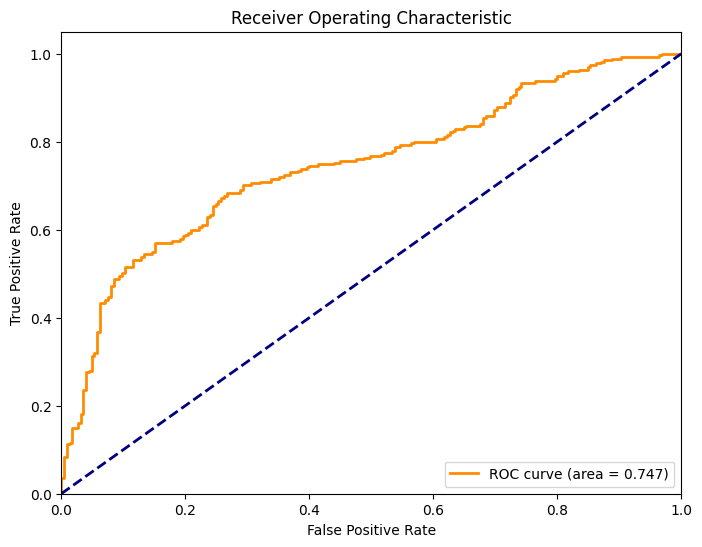

In [12]:
plt.figure(figsize=(8, 6))
test_labels = [int(elt) for elt in test_dataset['label']]
fpr, tpr, _ = roc_curve(test_labels, test_scores)
roc_auc = roc_auc_score(test_labels, test_scores)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4. Fine-Tune the model

In [13]:
def train_model(train_dataset, model, tokenizer, batch_size=32, epochs=1, lr=5e-6, device='cpu'):
    """
    Train the model on the given dataset.
    
    Args:
        train_dataset (datasets.Dataset): The training dataset.
        model (transformers.PreTrainedModel): The model to train.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer for encoding the texts.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train.
        lr (float): Learning rate for the optimizer.
        device (str): The device to run the model on ('cpu' or 'cuda').
    """
    # Adjust the model's classifier to have two output labels
    model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    model.num_labels = 2

    model.to(device)
    model.train()

    # Prepare optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # Prepare data loader
    def collate_fn(batch):
        texts = [item['text'] for item in batch]
        labels = torch.tensor([int(item['label']) for item in batch])  # Convert string labels to integers
        encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        return encodings.input_ids, encodings.attention_mask, labels

    data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(data_loader, desc=f"Epoch {epoch + 1}"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Average loss in epoch {epoch + 1}: {total_loss / len(data_loader)}")

In [ ]:
# Train the model
# train_model(train_dataset, model, tokenizer, device=torch.cuda.current_device())
train_model(train_dataset, model, tokenizer, device='cpu')

Epoch 1:   8%|████████▋                                                                                                        | 12/157 [03:06<37:21, 15.46s/it]

In [ ]:
test_scores = evaluate_batch(test_dataset['text'], positive_label=1, temperature=3.0)

In [ ]:
plt.figure(figsize=(8, 6))
test_labels = [int(elt) for elt in test_dataset['label']]
fpr, tpr, _ = roc_curve(test_labels, test_scores)
roc_auc = roc_auc_score(test_labels, test_scores)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save()